In [1]:
import xarray as xr
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as colors
%matplotlib inline
from pprint import pprint
import os
from datetime import datetime
import calendar
import pandas as pd
from scipy import stats
from scipy import special

/fs/site3/eccc/crd/ccrn/users/sah002/envs/sah002_env/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
def renameTimeDim(da):
    if 'time1' in da.dims:
        da2 = da.rename({'time1': 'time'})      
        return da2
    else: 
        return da

def make3DMeanPlot(ax, baseline, test, var, varname, index=None):
    baseline = renameTimeDim(baseline)
    test = renameTimeDim(test)

    blvar = baseline[var]
    tsvar = test[var]
    if isinstance(index, int):
        blvar = baseline[var][index]
        tsvar = test[var][index]
    
    bl = blvar.mean('time')
    tst = tsvar.mean('time')
    bl_err=2*blvar.std()
    tst_err=2*tsvar.std()
   
    ax.fill_betweenx(bl.level,bl-bl_err,bl+bl_err,alpha=0.2,color='b')
    ax.plot(bl, bl.level,'-bo',label='baseline')
    ax.fill_betweenx(tst.level,tst-tst_err,tst+tst_err,alpha=0.2,color='r')
    ax.plot(tst, tst.level, '-ro',label='test')
    ax.set_ylabel('Altitude')
    ax.set_xlabel(var + ' ['+ baseline[var].attrs['units'] +']')
    vmin,vmax = ax1.get_ylim()
    #ax.set_ylim(0,vmax+0.1*vmax)
    ax.legend()
    
   
    
    
def make3DPlot(baseline, test, var, varname, index=None,savefig=False, closefig=False, save_path=None):
    baseline = renameTimeDim(baseline)
    test = renameTimeDim(test)

    blvar = baseline[var]
    tsvar = test[var]
    if isinstance(index, int):
        blvar = baseline[var][index]
        tsvar = test[var][index]
            
    sperday = 86400
    fig = plt.figure(figsize=(14,12))
   
    ax1 = plt.subplot(2,2,1)
    im1 = ax1.pcolormesh(baseline.time/sperday, baseline.level, blvar.transpose())
    ax1.set_ylabel('Altitude')
    #ax1.set_xlabel('Time (days)')
    cb1 = fig.colorbar(im1, ax=ax1)
    cb1.ax.set_ylabel(var + ' ['+ blvar.attrs['units'] +']')
    vmin, vmax = im1.get_clim()
    ax1.set_title('Baseline')

    ax2 = plt.subplot(2,2,2)
    im2 = ax2.pcolormesh(test.time/sperday, test.level, tsvar.transpose())
    #ax2.set_xlabel('Time (days)')
    cb2 = fig.colorbar(im2, ax=ax2)
    im2.set_clim(vmin, vmax)
    cb2.ax.set_ylabel(var + ' ['+ blvar.attrs['units'] +']')
    ax2.set_title('Test')

    diff = tsvar-blvar
    
    ax3 = plt.subplot(2,2,3)
    im3 = ax3.pcolormesh(diff.time/sperday, diff.level, diff.transpose(), cmap=('RdBu_r'))
    cb3 = fig.colorbar(im3, ax=ax3)
    im3.set_clim(-vmax, vmax)
    ax3.set_xlabel('Time (days)')
    ax3.set_ylabel('Altitude')
    ax3.set_title('Absolute difference (Test-Baseline)')
    cb3.ax.set_ylabel(var + ' ['+ blvar.attrs['units'] +']')
    
    diff = ((tsvar/blvar)-1)*100
    
    max_diff = max(abs(np.amin(diff)),abs(np.amax(diff)))
    ax4 = plt.subplot(2,2,4)
    im4 = ax4.pcolormesh(diff.time/sperday, diff.level, diff.transpose(), cmap=('RdBu_r'), vmin=-max_diff, vmax=max_diff)
    cb4 = fig.colorbar(im4, ax=ax4)
    vmind, vmaxd = im3.get_clim()
    if vmaxd > 100:
            vmaxd = 100
    im4.set_clim(-vmaxd, vmaxd)
    ax4.set_xlabel('Time (days)')
    ax4.set_title('% difference')
    cb4.ax.set_ylabel('%')
    
    plt.suptitle(varname)

    if savefig == True:
        plt.savefig(save_path,bbox_inches='tight')
    if closefig == True:
        plt.close()   
    else:
        plt.show()
        
        
def make2DMeanPlot(ax,baseline, test, var, varname, savefig=False, closefig=False, save_path=None):        
    baseline = renameTimeDim(baseline)
    test = renameTimeDim(test)
    
    bl = baseline[var].mean('time')
    tst = test[var].mean('time')
    bl_err=2*baseline[var].std()
    tst_err=2*test[var].std()
    level = 100
    labels = ['old radiation code','updated radiation code']
   
    ax.errorbar(bl,  level, xerr=bl_err, capsize=10,  fmt='-b', label=labels[0], marker='o')
    ax.errorbar(tst, level, xerr=tst_err, capsize=10, fmt='-r', label=labels[1], marker='o')
    ax.set_ylabel('Altitude')
    ax.set_xlabel(var + ' ['+ baseline[var].attrs['units'] +']')
    ax.set_ylim(0,500)
    ax.legend()
    
    if savefig == True:
        plt.savefig(save_path,bbox_inches='tight')
    if closefig == True:
        plt.close()   

        
def make2DPlot(baseline, test, var, varname, savefig=False, closefig=False, save_path=None):
    baseline = renameTimeDim(baseline)
    test = renameTimeDim(test)
    
    bl = baseline[var]
    tst = test[var]
    
    sperday = 86400

    fig = plt.figure(figsize=(8,8))
   
    ax1 = plt.subplot(1,1,1)
    bl = ax1.plot(bl.time/sperday, baseline[var],'-bo',label='baseline')
    ts = ax1.plot(tst.time/sperday, test[var],'-ro',label='test')
    ax1.set_ylabel(var + ' ['+ baseline[var].attrs['units'] +']')
    ax1.set_xlabel('Time (days)')
    ax1.legend()
    
    plt.suptitle(varname)

    if savefig == True:
        plt.savefig(save_path,bbox_inches='tight')
    if closefig == True:
        plt.close()
        
    

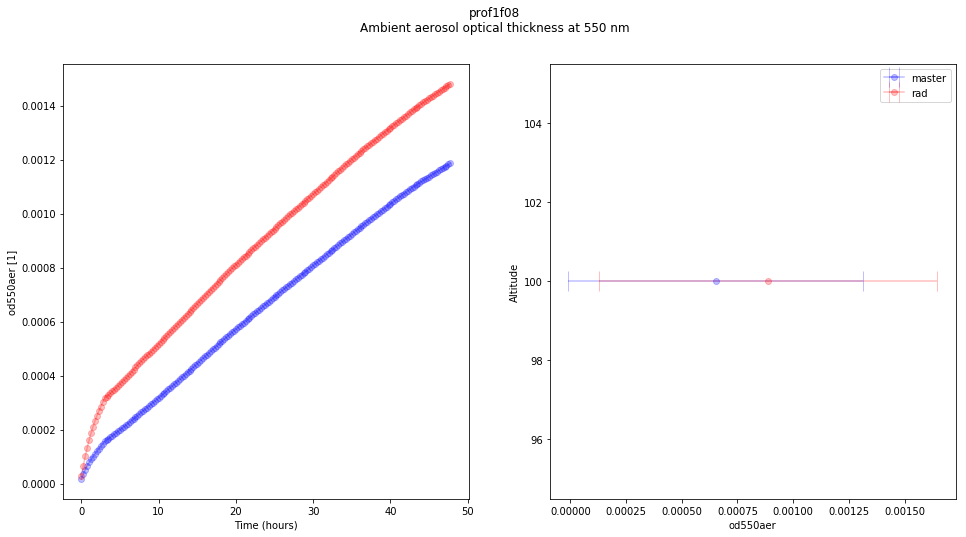

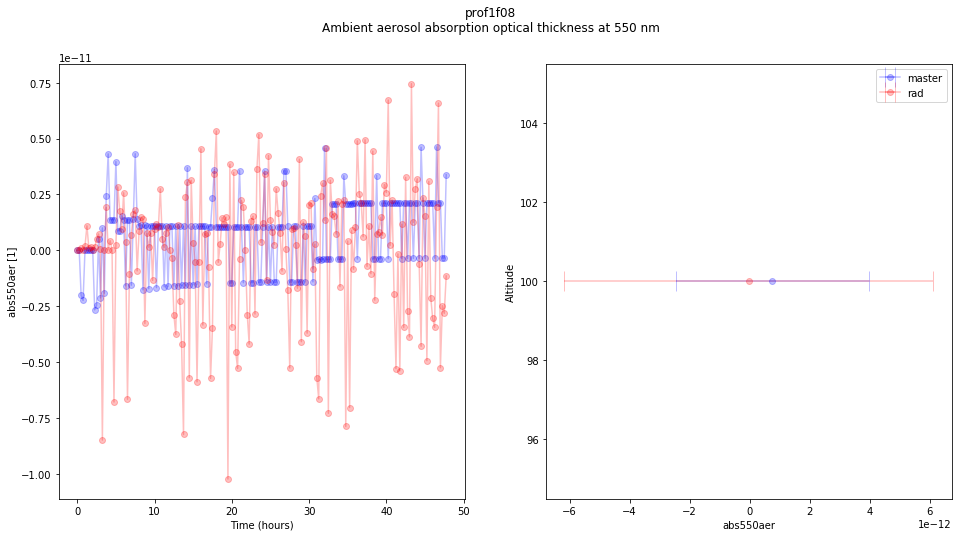

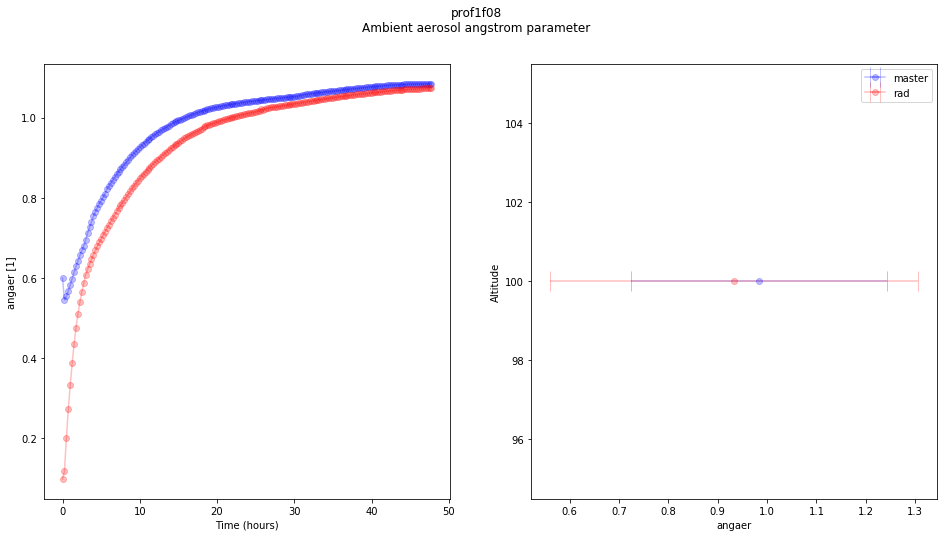

In [4]:
#timeseries and vertical profile

case_name =  'prof1f08'#'cloudy_polluted_cont' #'prof1f08', 'clear_polluted_desert' 'high_wind_ocean' clear_clean_desert

case1 = xr.open_dataset('/home/sah002/repos/pam/SCM_PAM/PAM/SCM/'+case_name+'_out_mstr.nc') 
#case2 = xr.open_dataset('/home/sah002/repos/pam/SCM_PAM/PAM/SCM/'+case_name+'_out_rad.nc')
#case3 = xr.open_dataset('/home/sah002/repos/pam/SCM_PAM/PAM/SCM/'+case_name+'_out_rad_tuness.nc')
case2 = xr.open_dataset('/home/sah002/repos/pam/SCM_PAM/PAM/SCM/'+case_name+'_out_rad_tune.nc')


cases =[case1, case2]#, case3,case4]
labels=['master','rad','rad-tuness', 'rad-tuneall', 'WHQt2']
colors=['b','r','g','m']
alphas=[0.25,0.25,0.25,0.25]

sperday = 86400
sperhr  = 3600

for var, da in cases[0].data_vars.items():
    if var in ['angaer', 'od550aer','abs550aer']:
        #print(var)
        try:
            fig = plt.figure(figsize=(16,8))
            ax1 = plt.subplot(1,2,1)
            for case,color,label,alpha in zip(cases,colors,labels,alphas):
                if len(da.dims) == 2:
                    c = case[var].isel(level=-1) #mean('level')
                    ax1.plot(c.time/sperhr, c,color=color,label=label,marker='o',alpha=alpha)
                if len(da.dims) == 1:
                    c = case[var]
                    ax1.plot(c.time/sperhr, c,color=color,label=label,marker='o',alpha=alpha)
            ax1.set_ylabel(var + ' ['+da.attrs['units'] + ']')
            ax1.set_xlabel('Time (hours)')
            y1,y2=(ax1.get_ylim())


            ax2 = plt.subplot(1,2,2)
            for case,color,label,alpha in zip(cases,colors,labels,alphas):
                if len(da.dims) == 2:
                    c = case[var].mean('time')
                    err=2*c.std()
                    ax2.fill_betweenx(c.level,c-err,c+err,alpha=alpha,color=color)
                    ax2.plot(c, c.level,marker='o',color=color,label=label,alpha=alpha)
                    ax2.set_ylabel('Altitude')
                    ax2.set_xlabel(var)
                    ax2.legend()
                if len(da.dims) == 1:
                    c = case[var].mean('time')
                    err=2*case[var].std()
                    ax2.errorbar(c,  100, xerr=err, capsize=10,color=color,label=label,alpha=alpha, marker='o')
                    ax2.set_ylabel('Altitude')
                    ax2.set_xlabel(var)
                    ax2.legend()

            plt.suptitle(case_name.replace('_', ' ')+'\n'+da.attrs['long_name'])
            #save_path = '/home/sah002/public_html/canam_intents2/v002/' + case_name + '_' + var + '.png'
            #plt.savefig(save_path,bbox_inches='tight')
            #plt.close()

        except:
            print('unable to plot: ',var)

            
   




In [ ]:
#timeseries and vertical profile

case_name =  'clear_polluted_desert'#'cloudy_polluted_cont' #'prof1f08', 'clear_polluted_desert' 'high_wind_ocean' clear_clean_desert

case1 = xr.open_dataset('/home/sah002/repos/pam/SCM_PAM/PAM/SCM/master/'+case_name+'_out.nc') 
case2 = xr.open_dataset('/home/sah002/repos/pam/SCM_PAM/PAM/SCM/master_wetrc_rad/'+case_name+'_out.nc')
case3 = xr.open_dataset('/home/sah002/repos/pam/SCM_PAM/PAM/SCM/radiation_update/'+case_name+'_out.nc')


cases =[case1,case2,case3]
labels=['old radiation code','old radiation code using wet particle size','updated radiation code']
colors=['b','g','r']
alphas=[0.5,0.5,0.5]

sperday = 86400
sperhr  = 3600

dbugs = {
    'dbug1':'SO4 aod 550nm',
    'dbug2':'SS aod 550nm',
    'dbug3':'MD aod 550nm',
    'dbug4':'BC aod 550nm',
    'dbug5':'OC aod 550nm',
    'dbug6':'total aod 550nm',
}

for var, da in cases[0].data_vars.items():
    if var in ['angaer','abs550aer','od550aer']:#var.startswith('dbug'):  #'angaer', ,'abs550aer'
        print(var)
       # try:
        fig = plt.figure(figsize=(16,8))
        ax1 = plt.subplot(1,2,1)
        for case,color,label,alpha in zip(cases,colors,labels,alphas):
            print(label)
            if len(da.dims) == 2:
                c = case[var].isel(level=-1) #mean('level')
                ax1.plot(c.time/sperhr, c,color=color,label=label,marker='o',alpha=alpha)
            if len(da.dims) == 1:
                c = case[var]
                ax1.plot(c.time/sperhr, c,color=color,label=label,marker='o',alpha=alpha)
        ax1.set_ylabel(var + ' ['+da.attrs['units'] + ']') #dbugs[var]
        ax1.set_xlabel('Time (hours)')
        y1,y2=(ax1.get_ylim())


        ax2 = plt.subplot(1,2,2)
        if len(da.dims) == 2:
                make3DMeanPlot(ax2,case1, case2, var, da.attrs['long_name'])
        if len(da.dims) == 1:
            for case,color,label,alpha in zip(cases,colors,labels,alphas): 
                c = case[var].mean('time')
                c_err=2*case[var].std()
                level = 100
                ax2.errorbar(c,  level, xerr=c_err, capsize=10,  color=color, label=label,  marker='o') #label=label+'\n'+str(c.values),
        ax2.legend()
        plt.suptitle(case_name.replace('_', ' ')+'\n'+da.attrs['long_name'])
        save_path = '/home/sah002/public_html/radiation_update/' + case_name + '_' + var + '.png'
        plt.savefig(save_path,bbox_inches='tight')
        plt.close()

        #except:
         #   print('unable to plot: ',var)

            
   




In [ ]:
#multi compare

case_names = ['cloudy_polluted_cont'] #['cloudy_polluted_cont','prof1f08', 'clear_polluted_desert', 'high_wind_ocean']

for case_name in case_names:
    #!ls -ltr /home/sah002/repos/pam/SCMtests/agebc_tests/*.nc
    case1 = xr.open_dataset('/home/sah002/repos/pam/SCMtests/agebc_tests/'+case_name+'_out_blOC.nc') 
    case2 = xr.open_dataset('/home/sah002/repos/pam/SCMtests/agebc_tests/'+case_name+'_out_skpOC.nc')

    cases =[case1,case2]
    labels=['master','test case']
    colors=['k','r','cyan','r','pink','m','#800026']
    alphas=[1,1,1,1,1]
    #colors=['k','#feb24c','#fd8d3c','#fc4e2a','#e31a1c','#bd0026','#800026']

    for var, da in cases[0].data_vars.items():
        if 'cn0' in var:
            #save_path = '../public_html/scm_cleanup/'+case_name+'/'+var+'_'+case_name+'.png'
            fig = plt.figure(figsize=(8,8))
            ax1 = plt.subplot(1,1,1)
            try:
                for case,color,label,alpha in zip(cases,colors,labels,alphas):
                    if len(da.dims) == 2:
                        c = case[var].mean('time')
                        c_err=2*case[var].std()
                        ax1.fill_betweenx(c.level-50,c-c_err,c+c_err,alpha=0.05,color=color)
                        ax1.plot(c, c.level-50,color=color,label=label,marker='o',alpha=alpha)
                    if len(da.dims) == 1:
                        c = case[var].mean('time')
                        c_err=2*case[var].std()
                        level = 100
                        ax1.errorbar(c,  level, xerr=c_err, capsize=10,  color=color, label=label,  marker='o') #label=label+'\n'+str(c.values),
                ax1.set_ylabel('Height (m)')
                ax1.set_xlabel(var)               
                ax1.legend()
                #ax1.set_xlim(0,20000)
                ax1.set_ylim(0,3000)
                #ax1.set_xscale('log')
                plt.suptitle(da.attrs['long_name'])
                #plt.savefig(save_path,bbox_inches='tight')
            except Exception as e: 
                print('skipping: ',var)
                print(e)  




In [ ]:
#tracer concs (raw)
for i in range(4,5,1):
    var='rtrac'
    if avg == True:
        make3DMeanPlot(case1, case2, var, str(i+1),index=i)
    else:    
        make3DPlot(case1, case2, var, str(i+1),index=i)


    fig = plt.figure(figsize=(8,8))
    ax1 = plt.subplot(1,1,1)
    bl = ax1.plot(case1.time/sperday, case1[var][i].mean('level'),'-bo',label='baseline')
    ts = ax1.plot(case2.time/sperday, case2[var][i].mean('level'),'-ro',label='test')
    ax1.set_ylabel(var + ' ['+ case1[var].attrs['units'] +']')
    ax1.set_xlabel('Time (days)')
    ax1.legend()
    plt.suptitle(var)


In [ ]:
#vertical profile

case =  'cloudy_polluted_cont'#'cloudy_polluted_cont' #'prof1f08', 'clear_polluted_desert' 'high_wind_ocean'

case1 = xr.open_dataset('/home/sah002/repos/pam/SCM_PAM/SCM/'+case_name+'_out.nc') 
case2 = xr.open_dataset('/home/sah002/repos/pam/SCM_PAM/SCM/scm_sunlithrs_test/'+case_name+'_out.nc')

avg = True

sperday = 86400
for var, da in case2.data_vars.items():
    #print(var,'-',da.attrs['long_name'], da.dims, da.attrs['units'])
    if len(da.dims) == 2:
        try:
            if avg == True:
                make3DMeanPlot(case1, case2, var, da.attrs['long_name'])
            else:    
                make3DPlot(case1, case2, var, da.attrs['long_name'])
        except:
            print('skipping ' + var)
    if len(da.dims) == 1:
        if avg == True:
            make2DMeanPlot(case1, case2, var, da.attrs['long_name'])
        else:    
            make2DPlot(case1, case2, var, da.attrs['long_name'])

                




In [ ]:
#time series

case_name =  'cloudy_polluted_cont'#'cloudy_polluted_cont' #'prof1f08', 'clear_polluted_desert' 'high_wind_ocean'

case1 = xr.open_dataset('/home/sah002/repos/pam/SCM_PAM/SCM/'+case_name+'_out.nc') 
case2 = xr.open_dataset('/home/sah002/repos/pam/SCM_PAM/SCM/scm_sunlithrs_test/'+case_name+'_out.nc')
cases =[case1,case2]
labels=['master','test case']
colors=['k','r','cyan','r','pink','m','#800026']
alphas=[1,1,1,1,1]

sperday = 86400
sperhr  = 3600

for var, da in cases[0].data_vars.items():
        print(var)
        try:
            fig = plt.figure(figsize=(8,8))
            ax1 = plt.subplot(1,1,1)
            for case,color,label,alpha in zip(cases,colors,labels,alphas):
                if len(da.dims) == 2:
                    c = case[var].mean('level')
                    ax1.plot(c.time/sperhr, c,color=color,label=label,marker='o',alpha=alpha)
                if len(da.dims) == 1:
                    c = case[var]
                    ax1.plot(c.time/sperhr, c,color=color,label=label,marker='o',alpha=alpha)
            ax1.set_ylabel(da.attrs['units'])
            ax1.set_xlabel('Time (hours)')
            y1,y2=(ax1.get_ylim())
            ax1.set_ylim(y1-2e-17,y2+2e-17)
            ax1.set_xlim(0,25)
            ax1.legend()
            plt.suptitle(da.attrs['long_name'])

            #plt.savefig(save_path,bbox_inches='tight')

        except Exception as e: 
            print('skipping: ',var)
            print(e)   


In [ ]:
#multi var with save

avg = True

for case in ['cloudy_polluted_cont','clear_polluted_desert']:#,'cloudy_polluted_cont','clear_polluted_desert']:#,'cloudy_polluted_cont']:#,'high_wind_ocean','clear_polluted_desert','clear_clean_arctic']:
    print(case)
    
    baseline = xr.open_dataset('/home/sah002/repos/pam/SCM_PAM/SCM/'+case+'_out_master_5d_suloxi.nc')
    test     = xr.open_dataset('/home/sah002/repos/pam/SCM_PAM/SCM/'+case+'_out_PAMFQ2_SSFQ1_5d_suloxi.nc')
    for var, da in baseline.data_vars.items():
       
        #print(var,'-',da.attrs['long_name'], da.dims, da.attrs['units'])

        if avg == True:
            save_path = '../public_html/PAM_optimization/PAM_step/'+case+'_SSGEN/'+var+'_SCM.png'
        else:
            save_path = '../public_html/PAM_optimization/PAM_step/'+case+'_SSGEN_ts/'+var+'_SCM.png'
        if len(da.dims) == 2:
            try:
                if avg == True:
                    make3DMeanPlot(baseline, test, var, da.attrs['long_name'], savefig=True, closefig=True, save_path=save_path)
                else:    
                    make3DPlot(baseline, test, var, da.attrs['long_name'], savefig=True, closefig=True, save_path=save_path)
            except:
                print('skipping ' + var)
        if len(da.dims) == 1:
            if avg == True:
                make2DMeanPlot(baseline, test, var, da.attrs['long_name'], savefig=True, closefig=True, save_path=save_path)
            else:    
                make2DPlot(baseline, test, var, da.attrs['long_name'], savefig=True, closefig=True, save_path=save_path)


In [ ]:
#time series

case =  'cloudy_polluted_cont'#'cloudy_polluted_cont' #'prof1f08', 'clear_polluted_desert' 'high_wind_ocean'

case1 = xr.open_dataset('/home/sah002/repos/pam/SCM_PAM/SCM/'+case+'_tini.nc') 
case2 = xr.open_dataset('/home/sah002/repos/pam/SCM_PAM/SCM/'+case+'_tini_cl.nc')
cases =[case1,case2]
labels=['master','cleanup']
colors=['k','r','cyan','r','pink','m','#800026']
alphas=[1,1,1,1,1]



sperday = 86400

print(cases[0]['pscb'])
for var, da in cases[0].data_vars.items():
    if 'cn0' in var:
        try:
            fig = plt.figure(figsize=(8,8))
            ax1 = plt.subplot(1,1,1)
            for case,color,label,alpha in zip(cases,colors,labels,alphas):
                c = case[var]

                ax1.plot(c, c.level,color=color,label=label,marker='o',alpha=alpha)
            ax1.set_ylabel(da.attrs['units'])
            ax1.set_xlabel('Time (days)')
            ax1.legend()
            plt.suptitle(da.attrs['long_name'])

            #plt.savefig(save_path,bbox_inches='tight')

        except Exception as e: 
            print('skipping: ',var)
            print(e)   
